In [1]:
from __future__ import print_function

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline
# constants for all plots
x_label = '$\lambda$($\mu$)'
y_label = 'erg.cm$^{-2}$.s$^{-1}$.$A^{-1}$'
plot_axis = [0.8, 2.4, 2.8e-15, 4.e-15]

data = np.genfromtxt("data/example_spec_ipac.txt")
wave = data[:,0]
flux = data[:,1]

In [2]:
# two ROIs
indices = (wave > 1.09) & (wave < 2.25) 
w1 = wave[indices]
f1 = flux[indices]
indices = (wave > 0.9) & (wave < 2.35) 
w2 = wave[indices]
f2 = flux[indices]

In [3]:
# build first guesses from the data at hand.
from astropy.modeling import models

def initialize_gaussian(w, f):
    centroid = np.sum(w * f) / np.sum(f)

    dw = w - np.mean(w)
    fwhm = 2 * np.sqrt(np.sum((dw * dw) * f) / np.sum(f))
    sigma = fwhm / 2.355

    delta_w = w[1:] - w[:-1]
    sum_f = np.sum((f[1:] - np.min(f[1:])) * delta_w)
    height = sum_f / (sigma * np.sqrt( 2 * np.pi))
    
    return height, centroid, sigma

def initialize_linear(w, f):
    # compute averages at the 5% of data at each extreme of the wavelength range.
    l = int(len(w) / 20)
    w1 = np.mean(w[0:l])
    w2 = np.mean(w[-l-1:-1])
    f1 = np.mean(f[0:l])
    f2 = np.mean(f[-l-1:-1])
    # fit a straigth line thru these 
    slope = (f2 - f1) / (w2 - w1)
    inter = f2 - slope * w2
    return slope, inter

def initialize_compound(w, f):
    slope, inter = initialize_linear(w, f)
    fc = f - (w * slope + inter)
    height, centroid, sigma = initialize_gaussian(w, fc)
    return height, centroid, sigma, slope, inter

In [4]:
# first guesses
height1, centroid1, sigma1, slope1, inter1 = initialize_compound(w1, f1)
height2, centroid2, sigma2, slope2, inter2 = initialize_compound(w2, f2)

p1 = [height1, centroid1, sigma1, slope1, inter1]
p2 = [height2, centroid2, sigma2, slope2, inter2]

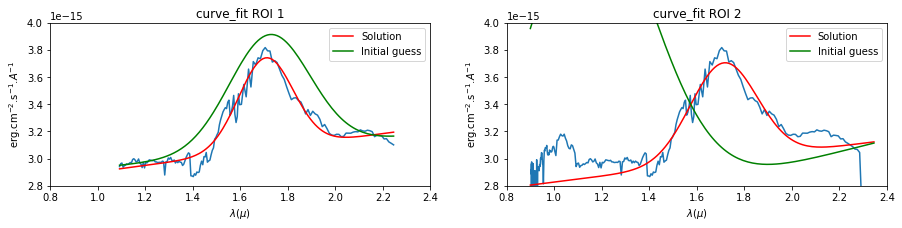

In [5]:
# 'scipy.optimize.curve_fit' is mostly a convenience wrapper around two 
# functions, 'scipy.optimize.leastsq' and 'scipy.optimize.least_squares'.
#
# 'leastsq' is in turn a wrapper around MINPACK’s lmdif and lmder algorithms.
# These are implementations of the L-M algorithm. Which one gets called depends 
# on the user providing a callable to compute the Jacobian. If not provided, 
# it's estimated. 
#
# astropy's LevMarLSQFitter is basically a wrapper around 'leastsq' as well.
# The add-on factor is that it handles the constraints and ties that are an
# integral part os astropy's fitting mechanism, but are not recognized by the 
# scipy routines. Thus there is no point in attempting to add 'curve_fit' (with 
# the default 'lm' method) or 'leastsq' to specviz's fitters drop-down menu. 
# The functionality is already all there.

from scipy.optimize import curve_fit

# model to be fitted
def func(x, a, x0, sigma, slope, intercept):
    return (models.Gaussian1D(amplitude=a, mean=x0, stddev=sigma) + \
            models.Linear1D(slope=slope, intercept=intercept))(x)

# Calling 'curve_fit' with initial guesses for the parameters does not work 
# regardless of the combination of first guesses and  methods used.
# 
# These calls either raise an exception when reaching maxfev, or just skip
# everything and return the first guesses as the answer. 
#
# Note that method 'lm' basically calls the same 'leastsq' function used by 
# astropy's L-M fitter. It can't deal with bounds though; for that, method 
# 'trf' would be required.

# popt1, pcov1 = curve_fit(func, w1, f1, p0=p1, method='lm', maxfev=10000)
# popt2, pcov2 = curve_fit(func, w2, f2, p0=p2, method='lm', maxfev=10000)

# Not providing first guesses or method: this will runs the 'lm' method and
# uses default first guesses. Surprisingly (for ROI 2), it seems to work.
popt1, pcov1 = curve_fit(func, w1, f1)
popt2, pcov2 = curve_fit(func, w2, f2)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, func(w1, popt1[0], popt1[1], popt1[2], popt1[3], popt1[4]), color='red', label='Solution')
plt.plot(w1, func(w1, p1[0], p1[1], p1[2], p1[3], p1[4]), color='green', label="Initial guess")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("curve_fit ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, func(w2, popt2[0], popt2[1], popt2[2], popt2[3], popt2[4]), color='red', label='Solution')
plt.plot(w2, func(w2, p2[0], p2[1], p2[2], p2[3], p2[4]), color='green', label="Initial guess")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("curve_fit ROI 2")


8 [  6.43487300e-16   1.71843563e+00   1.28950671e-01   2.38568051e-16
   2.64923433e-15]
1 [  5.00000000e-16   1.70000000e+00   2.64752951e-01   2.50000000e-16
   2.50000000e-15]


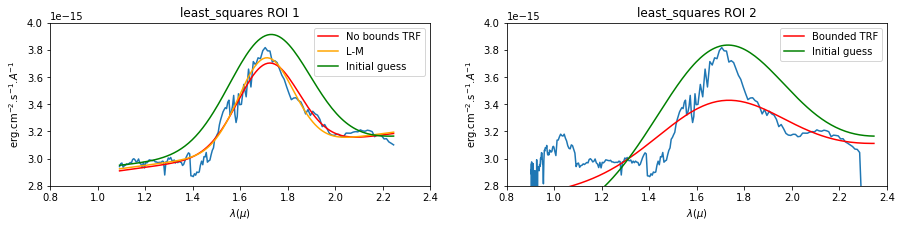

In [6]:
# 'scipy.optimize.least_squares' gives access to three different 
# optimizers: 'lm', 'trf', and 'dogbox'. With 'lm' it defaults to
# calling 'leastsq'. Any benefit provided by including 'least_squares'
# in specviz would come then from its ability to run the 'trf' and
# 'dogbox' algorithms. 
# 
# Both 'trf' and 'dogbox' are the only algorithms in scipy capable of
# handling bounds. These might be of interest in the future; here, we 
# run some experiments with bounds. Note that, to add 'least_squares'
# to specviz's code, it should be re-cast into the astropy Fitter meta
# class framework, and implement code that handles constraints and ties 
# (a non-trivial task, likely.
# 
# 'least_squares' provides a rich set of input parameters to control 
# and monitor the fitting process. These abilities are probably beyond 
# the scope of specviz.

from scipy.optimize import least_squares

def func_res(p, x, y):
    return (models.Gaussian1D(amplitude=p[0], mean=p[1], stddev=p[2]) + \
            models.Linear1D(slope=p[3], intercept=p[4]))(x) - y

p2[1] = 1.7 # force it to be close to the peak
p2[0] = 1.e-15

res_lsq_1 = least_squares(func_res, np.array(p1), args=(w1, f1), gtol=1.E-15, xtol=1.E-15, ftol=1.E-15) 
res_lsq_1_lm = least_squares(func_res, np.array(p1), method='lm', args=(w1, f1), gtol=1.E-15, xtol=1.E-15, ftol=1.E-15) 
res_lsq_2 = least_squares(func_res, np.array(p2), args=(w2, f2), \
                          bounds=([0.0,    1.5,  0.0,  0.0,    2.e-15],\
                                  [1.e-15, 1.9,  0.5,  5.e-16, 3.e-15]), gtol=1.E-15, xtol=1.E-15, ftol=1.E-15) 

s1 = res_lsq_1['x']
s1_lm = res_lsq_1_lm['x']
s2 = res_lsq_2['x']

print(res_lsq_1['nfev'], s1)
print(res_lsq_2['nfev'], s2)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, func(w1, s1[0], s1[1], s1[2], s1[3], s1[4]), color='red', label='No bounds TRF')
plt.plot(w1, func(w1, s1_lm[0], s1_lm[1], s1_lm[2], s1_lm[3], s1_lm[4]), color='orange', label='L-M')
plt.plot(w1, func(w1, p1[0], p1[1], p1[2], p1[3], p1[4]), color='green', label="Initial guess")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("least_squares ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, func(w2, s2[0], s2[1], s2[2], s2[3], s2[4]), color='red', label='Bounded TRF')
plt.plot(w2, func(w2, p2[0], p2[1], p2[2], p2[3], p2[4]), color='green', label="Initial guess")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("least_squares ROI 2")

### ODRPACK

Orthogonal Distance Regression is designed to handle the case where errors are present in both the independent and dependent variables. This is probably not the most common use case in spectroscopy in the UV-IR band, so there might be not much of a point in adding this to specviz. ODRPACK uses a modified trust-region L-M optimizer. According to the original paper, it falls back into ordinary L-M (as in optimize.leastsq) when errors in wavelength are to be ignored. Although it's not clear that the particular implementation of ODRPACK can be more efficient than MINPACK's L-M (optimize.leastsq). Like astropy's fitters, it supports constrained (fixed) parameters, but no bounded parameters.

This is the example straight from https://github.com/tiagopereira/python_tips/wiki/Scipy:-curve-fitting

In [7]:
# This notebook cell contains the exact same code as in the doc page above.
#
# Note that the Gaussian as defned in here is not the same as the Gaussian
# defined in astropy's Gaussian1D model. The code we use elsewhere in this 
# script to compute first guesses for the Gaussian parameters is based on 
# astropy's Gaussian formulation though. This may lead to somewhat different 
# first guesses when mixing together both representations.

import math
from scipy.odr import odrpack as odr
from scipy.odr import models

def gaussian(B,x):
    ''' Returns the gaussian function for B=m,stdev,max,offset '''
    return B[3]+B[2]/(B[1]*math.sqrt(2*math.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))

def gauss_lsq(x,y,verbose=False,itmax=200,iparams=[]):
    ''' Performs a gaussian least squares fit to the data,
    with errors! Uses scipy odrpack, but for least squares.'''

    def _gauss_fjd(B,x):
        # Analytical derivative of gaussian with respect to x
        return 2*(x-B[0])*gaussian(B,x)

    def _gauss_fjb(B,x):
        # Analytical derivatives of gaussian with respect to parameters
        _ret = np.concatenate(( -2*(x-B[0])*gaussian(B,x),\
                             ((x-B[0])**2/(2*B[1]**2)-1)/B[1]*gaussian(B,x),\
                             gaussian(B,x)/B[2] ,\
                             np.ones(x.shape, float) ))
        _ret.shape = (4,) + x.shape
        return _ret
    
    # Centre data in mean(x) (makes better conditioned matrix)
    mx = np.mean(x)
    x2 = x - mx
    
    if not any(iparams):
        # automatic guessing of gaussian's initial parameters (saves iterations)
        iparams = np.array([x2[np.argmax(y)],np.std(y),math.sqrt(2*math.pi)*np.std(y)*np.max(y),1.])
        
        print("iparams: ", iparams)

    gauss  = odr.Model(gaussian, fjacd=_gauss_fjd, fjacb=_gauss_fjb)
    mydata = odr.Data(x2, y)
    myodr  = odr.ODR(mydata, gauss, beta0=iparams, maxit=itmax)

    # Set type of fit to least-squares:
    myodr.set_job(fit_type=2)
    if verbose == 2: myodr.set_iprint(final=2)
            
    fit = myodr.run()
    
    # Display results:
    if verbose:
        fit.pprint()
        print('Re-centered Beta: [%f  %f  %f %f]' % \
              (fit.beta[0]+mx,fit.beta[1],fit.beta[2],fit.beta[3]))

    itlim = False
    if fit.stopreason[0] == 'Iteration limit reached':
        itlim = True
        print('(WWW) gauss_lsq: Iteration limit reached, result not reliable!')

    # Results and errors
    coeff = fit.beta
    coeff[0] += mx # Recentre in original axis
    err   = fit.sd_beta

    return coeff,err,itlim

The example above assumes a constant baseline, and our data has a slant baseline. So we first subtract the baseline, then fit, then add back the baseline previously subtracted. Note that this may introduce correlated errors in case we use this procedure to compute errors for the function parameters. The correct way to treat the slanted baseline would be to modify the functional form above to include the linear first-order term.

In [8]:
# get first guess estimates
h1, c1, s1, slope1, inter1 = initialize_compound(w1, f1)
h2, c2, s2, slope2, inter2 = initialize_compound(w2, f2)

# subtract baseline from the data
f1_0 = f1 - (slope1 * w1 + inter1)
f2_0 = f2 - (slope2 * w2 + inter2)

# The example code above requires that the gaussian center 
# position be defined wrt the wavelength mean.
c1 -= np.mean(w1)
c2 -= np.mean(w2)

# initial estimates. Offset is zero by construction.
iparams1 = [c1, s1, h1, 0.0]
iparams2 = [c2, s2, h2, 0.0]

# iparams = [0.1, 0.13, 1.5e-16, 0.0]

In experimenting with this script, we find that first guesses are necessary to achieve any meaningful result.

In [9]:
# fit
fit1, errors, itlim = gauss_lsq(w1, f1_0, verbose=True,itmax=5000, iparams=iparams1)
print("Result for ROI 1: ", fit1)
print("Errors: ", errors)
print(itlim)

fit2, errors, itlim = gauss_lsq(w2, f2_0, verbose=True,itmax=5000, iparams=iparams2)
print("Result for ROI 2: ", fit2)
print("Errors: ", errors)
print(itlim)

Beta: [  1.40863278e-01   1.17974922e-01   2.01661618e-16  -4.80306903e-18]
Beta Std Error: [  3.04274888e-03   3.42454424e-03   6.19892743e-18   6.86778525e-18]
Beta Covariance: [[  2.34886542e+27   5.38655689e+26   8.42919015e+11  -1.11569964e+11]
 [  5.38655689e+26   2.97530487e+27   3.50432766e+12  -3.05284621e+12]
 [  8.42919015e+11   3.50432766e+12   9.74897633e-03  -7.48662346e-03]
 [ -1.11569964e+11  -3.05284621e+12  -7.48662346e-03   1.19662845e-02]]
Residual Variance: 3.94161397062733e-33
Inverse Condition #: 0.06425802752230925
Reason(s) for Halting:
  Sum of squares convergence
Re-centered Beta: [1.711606  0.117975  0.000000 -0.000000]
Result for ROI 1:  [  1.71160579e+00   1.17974922e-01   2.01661618e-16  -4.80306903e-18]
Errors:  [  3.04274888e-03   3.42454424e-03   6.19892743e-18   6.86778525e-18]
False
Beta: [  2.90959954e-01   1.09889333e+01   5.56051328e-12  -2.01342201e-13]
Beta Std Error: [  1.18662572e-02   2.09473578e+02   3.17761318e-10   7.68794442e-12]
Beta Cov

In [10]:
# add slanted baselines back to solution
f1_fit = gaussian(fit1, w1) + (slope1 * w1 + inter1)
f2_fit = gaussian(fit2, w2) + (slope2 * w2 + inter2)

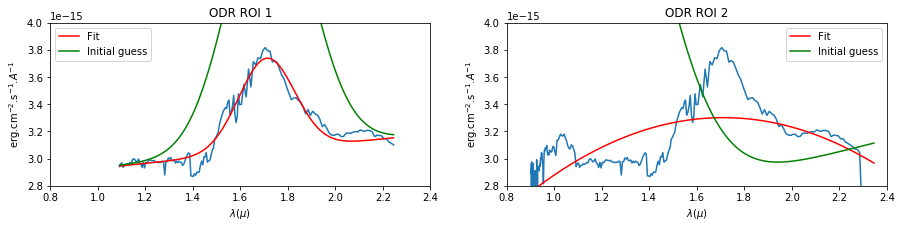

In [11]:
# plot results

# to plot the first guess, we put back the wavelength mean.
iparams1[0] += np.mean(w1)
iparams2[0] += np.mean(w2)
f1_init = gaussian(iparams1, w1) + (slope1 * w1 + inter1)
f2_init = gaussian(iparams2, w2) + (slope2 * w2 + inter2)

# first guess values derived in this way are not the same as 
# first guesses derived elsewhere using astropy's Gaussian 
# formuation, as per explanation in cell [7]

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, f1_fit, color='red', label='Fit')
plt.plot(w1, f1_init, color='green', label="Initial guess")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("ODR ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, f2_fit, color='red', label='Fit')
plt.plot(w2, f2_init, color='green', label="Initial guess")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("ODR ROI 2")